In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns 
import plotly.express as px
import joblib

from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, roc_auc_score, confusion_matrix
from matplotlib.colors import ListedColormap

#Classifiers
from xgboost import XGBClassifier
from catboost import CatBoostClassifier


from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler

import time
import warnings
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv('./dataset/Dataset.csv')
df.head(5)

,PIPE_NO,DV_R,DA_R,AV_R,AA_R,PM_R,FIN_JGMT
0,PP22033000042,318,7798,365,7177,9507,1
1,PP22033000042,318,7798,365,7177,9507,1
2,PP22033000042,316,8479,380,8846,9484,1
3,PP22033000042,316,8479,380,8846,9484,1
4,PP22033000042,309,7603,351,5726,9840,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 739888 entries, 0 to 739887
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   PIPE_NO   739888 non-null  object
 1   DV_R      739888 non-null  int64 
 2   DA_R      739888 non-null  int64 
 3   AV_R      739888 non-null  int64 
 4   AA_R      739888 non-null  int64 
 5   PM_R      739888 non-null  int64 
 6   FIN_JGMT  739888 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 39.5+ MB


In [4]:
#numerical: discrete & continuous
discrete = [var for var in df.columns if df[var].dtype !='O' and var != 'FIN_JGMT' and df[var].nunique() < 10] 
continuous = [var for var in df.columns if df[var].dtype !='O' and var !='FIN_JGMT' and var not in discrete]

#categorical 
categorical = [var for var in df.columns if df[var].dtype== 'O']

print("Current dataset contains:")
print('\n  {} numerical variables,'.format(len(discrete) + len(continuous), 'including:'))
print('     {} discrete variables:'.format(len(discrete)), list(df[discrete].columns))
print('     {} continuous variables:'.format(len(continuous)), list(df[continuous].columns))
print('\n  {} categorical variables:'.format(len(categorical)), list(df[categorical].columns))


Current dataset contains:

  5 numerical variables,
     0 discrete variables: []
     5 continuous variables: ['DV_R', 'DA_R', 'AV_R', 'AA_R', 'PM_R']

  1 categorical variables: ['PIPE_NO']


In [5]:
df.describe()

,DV_R,DA_R,AV_R,AA_R,PM_R,FIN_JGMT
count,739888.000000,739888.000000,739888.000000,739888.000000,7.398880e+05,739888.000000
mean,326.640292,6890.474566,376.151258,5760.547448,9.609554e+03,0.846198
std,254.756693,1340.889458,455.283380,758.968542,8.761484e+04,0.360759
min,1.000000,1.000000,11.000000,1.000000,2.000000e+00,0.000000
25%,309.000000,6156.000000,341.000000,5631.000000,9.285000e+03,1.000000
50%,310.000000,6979.000000,349.000000,5818.000000,9.569000e+03,1.000000
75%,316.000000,7857.000000,354.000000,5993.000000,9.832000e+03,1.000000
max,12680.000000,13701.000000,10984.000000,78935.000000,5.076137e+07,1.000000


- **DV_R** - Arc voltage
- **DA_R** - Arc current
- **AV_R** - Wire feed speed
- **AA_R** - Wire feed current
- **PM_R** - Power

In [6]:
df.isnull().sum()

PIPE_NO     0
DV_R        0
DA_R        0
AV_R        0
AA_R        0
PM_R        0
FIN_JGMT    0
dtype: int64

In [7]:
labels = ['Pass', 'Fail']

Pass_or_Fail = df['FIN_JGMT'].value_counts().tolist()
values = [Pass_or_Fail[0], Pass_or_Fail[1]]

fig = px.pie(values=df['FIN_JGMT'].value_counts(), names=labels, 
            width=700, height=400,
            color_discrete_sequence=['green', 'red'], 
            title='Pass or Fail')
fig.show()

#### <span style='color:red'> We can notice that the ratio of our defective parts to normal parts is 6 to one

<Axes: >

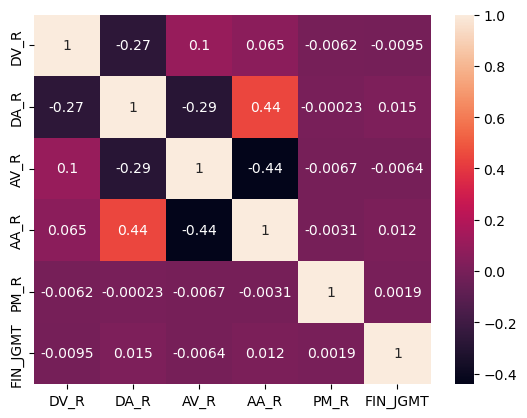

In [8]:
#correlation coeffitients with heatmap 
df_corr = df.drop(['PIPE_NO'], axis=1)
corr = df_corr.corr()

sns.heatmap(
    corr, 
    annot= True,
    xticklabels=corr.columns.values, 
    yticklabels=corr.columns.values
)

#### <span style='color:red'>From the correlation matrix we can notice that our changes do not correlate

In [9]:
# drop PIPE_NO columns and split data
X = df.drop(['PIPE_NO', 'FIN_JGMT'], axis=1)
y = df['FIN_JGMT']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

X_train.shape, X_test.shape

((591910, 5), (147978, 5))

### <span style='color:green'>Definition of balancing methods

In [11]:
balancing_methods = {
    'No Balancing': None, 
    'RandomOverSampler': RandomOverSampler(random_state=42), 
    'RandomUnderSampler': RandomUnderSampler(random_state=42),
    'SMOTE': SMOTE(random_state=42), 
    'ADASYN': ADASYN(random_state=42)
}

### <span style='color:green'>Models Definition

In [12]:
models = {
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'), 
    'CatBoost': CatBoostClassifier(random_state=42, verbose=False)
}

### <span style='color:green'> Grid_search Parameters

In [13]:
param_grids = {
    
    'XGBoost': {
        'n_estimators': [50, 100], 
        'max_depth': [3, 6], 
        'learning_rate':[0.1, 0.2]
    }, 
    'CatBoost': { 
        'iterations': [50, 100],
        'depth': [4, 6], 
        'learning_rate': [0.1, 0.2]
    }
}

In [14]:
results = []

### <span style='color:red'> Training models with different balancing methods

In [15]:
for balance_name, balance_method in balancing_methods.items(): 
    print(f'\n+++ Balancing Methods: {balance_name} +++')

    # Use balancing 
    if balance_method is None: 
        X_train_balanced = X_train
        y_train_balanced = y_train
    else: 
        X_train_balanced, y_train_balanced = balance_method.fit_resample(X_train, y_train)

    print(f'Balanced Size: {X_train_balanced.shape}')
    print(f'Class distribution: {Counter(y_train_balanced)}')


    for model_name, model in models.items(): 
        print(f'\nTraining {model_name}')

        # Timer 
        start_time = time.time()

        # Grid_search 
        grid_search = GridSearchCV(
            model, 
            param_grids[model_name], 
            cv=3, 
            scoring='roc_auc', 
            n_jobs=-1, 
            verbose=0
        )

        grid_search.fit(X_train_balanced, y_train_balanced)

        training_time = time.time() - start_time

        best_model = grid_search.best_estimator_

        #Preds 
        y_train_preds = best_model.predict(X_train_balanced)
        y_test_pred = best_model.predict(X_test)

        # Metrix 
        train_roc_auc = roc_auc_score(
            y_train_balanced,
            best_model.predict_proba(X_train_balanced)[:, 1])
        
        test_roc_auc = roc_auc_score(
            y_test,
            best_model.predict_proba(X_test)[:, 1])

        train_f1 = f1_score(y_train_balanced, y_train_preds)
        test_f1 = f1_score(y_test, y_test_pred)

        # Cclassification_report

        train_classification_report = classification_report(
            y_train_balanced, y_train_preds, 
            target_names=['Defect', 'Normal'], 
            output_dict=True
        )

        test_classification_report = classification_report(
            y_test, 
            y_test_pred, 
            target_names=['Defect', 'Normal'], 
            output_dict=True
        )

        # Save_Results
        results.append({
            'Balancing': balance_name, 
            'Model': model_name, 
            'Best_Params': grid_search.best_params_, 
            'Train_ROC_AUC': train_roc_auc, 
            'Test_ROC_AUC': test_roc_auc, 
            'Train_F1': train_f1,
            'Test_F1': test_f1, 
            'Training_Time': training_time, 
            'Best_Model': best_model,
            'Train_Classification_Report': train_classification_report, 
            'Test_Classification_Report': test_classification_report
        })

        print(f'Best Parametors: {grid_search.best_params_}')
        print(f"ROC_AUC train set: {train_roc_auc:.4f}")
        print(f'ROC AUC test set: {test_roc_auc:.4f}')
        print(f'F1 train_set: {train_f1:.4f}')
        print(f'F1 test_set: {test_f1:.4f}')
        print(f'Training Time: {training_time:.2f} sec.')

        print('\n +++ Train Classification_Report +++')
        print(classification_report(y_train_balanced, y_train_preds, 
                                   target_names=['Defect', 'Normal']))

        print('\n +++ Test Classification_Report +++')
        print(classification_report(y_test, y_test_pred, 
                                   target_names=['Defect', 'Normal']))

print('\n+++ FINISH +++')


+++ Balancing Methods: No Balancing +++
Balanced Size: (591910, 5)
Class distribution: Counter({1: 500873, 0: 91037})

Training XGBoost
Best Parametors: {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 100}
ROC_AUC train set: 0.9862
ROC AUC test set: 0.9855
F1 train_set: 0.9709
F1 test_set: 0.9701
Training Time: 12.50 sec.

 +++ Train Classification_Report +++
              precision    recall  f1-score   support

      Defect       0.89      0.77      0.83     91037
      Normal       0.96      0.98      0.97    500873

    accuracy                           0.95    591910
   macro avg       0.93      0.88      0.90    591910
weighted avg       0.95      0.95      0.95    591910


 +++ Test Classification_Report +++
              precision    recall  f1-score   support

      Defect       0.89      0.77      0.82     22759
      Normal       0.96      0.98      0.97    125219

    accuracy                           0.95    147978
   macro avg       0.92      0.87      0.90    1

In [16]:
results_df = pd.DataFrame(results)

display_df = results_df.drop(['Best_Model', 'Train_Classification_Report', 'Test_Classification_Report'], axis=1).copy()

display_df['Train_ROC_AUC'] = display_df['Train_ROC_AUC'].round(4)
display_df['Test_ROC_AUC'] = display_df['Test_ROC_AUC'].round(4)
display_df['Train_F1'] = display_df['Train_F1'].round(4)
display_df['Test_F1'] = display_df['Test_F1'].round(4)
display_df['Training_Time'] = display_df['Training_Time'].round(2) 

print(display_df)

best_idx = results_df['Test_ROC_AUC'].idxmax()
best_result = results_df.iloc[best_idx]

print(f'\n\n+++ Best Model with ROC_AUC +++')
print(f'{best_result["Balancing"]}')
print(f'Model: {best_result["Model"]}')
print(f'Best parameters: {best_result["Best_Params"]}')
print(f'Train ROC_AUC: {best_result["Train_ROC_AUC"]:.4f}')
print(f'Test ROC_AUC: {best_result["Test_ROC_AUC"]:.4f}')
print(f'Train F1: {best_result["Train_F1"]:.4f}')
print(f'Test F1: {best_result["Test_F1"]:.4f}')
print(f'Training Time: {best_result["Training_Time"]:.2f} sec.')

best_model = best_result['Best_Model']

            Balancing     Model  \
0        No Balancing   XGBoost   
1        No Balancing  CatBoost   
2   RandomOverSampler   XGBoost   
3   RandomOverSampler  CatBoost   
4  RandomUnderSampler   XGBoost   
5  RandomUnderSampler  CatBoost   
6               SMOTE   XGBoost   
7               SMOTE  CatBoost   
8              ADASYN   XGBoost   
9              ADASYN  CatBoost   

                                         Best_Params  Train_ROC_AUC  \
0  {'learning_rate': 0.2, 'max_depth': 6, 'n_esti...         0.9862   
1  {'depth': 6, 'iterations': 100, 'learning_rate...         0.9794   
2  {'learning_rate': 0.2, 'max_depth': 6, 'n_esti...         0.9864   
3  {'depth': 6, 'iterations': 100, 'learning_rate...         0.9799   
4  {'learning_rate': 0.2, 'max_depth': 6, 'n_esti...         0.9862   
5  {'depth': 6, 'iterations': 100, 'learning_rate...         0.9801   
6  {'learning_rate': 0.2, 'max_depth': 6, 'n_esti...         0.9873   
7  {'depth': 6, 'iterations': 100, 'learning_r

In [17]:
catboost_results = results_df[results_df['Model'] == 'CatBoost']
best_catboost_idx = catboost_results['Test_ROC_AUC'].idxmax()
best_catboost = results_df.iloc[best_catboost_idx]

In [18]:
print('+++ Best Catboost Model +++')
print(f'\nBalancing : {best_catboost["Balancing"]}')
print(f'Best Parameters : {best_catboost["Best_Params"]}')
print(f'ROC_AUC on Train set : {best_catboost["Train_ROC_AUC"]:.4f}')
print(f'ROC_AUC on Test set : {best_catboost["Test_ROC_AUC"]:.4f}')
print(f'F1 on Train set : {best_catboost["Train_F1"]:.4f}')
print(f'F1 on Test set : {best_catboost["Test_F1"]:.4f}')
print(f'Training Time : {best_catboost["Training_Time"]:.2f} sec.')

+++ Best Catboost Model +++

Balancing : RandomUnderSampler
Best Parameters : {'depth': 6, 'iterations': 100, 'learning_rate': 0.2}
ROC_AUC on Train set : 0.9801
ROC_AUC on Test set : 0.9794
F1 on Train set : 0.9222
F1 on Test set : 0.9380
Training Time : 11.89 sec.


In [19]:
best_catboost_model = best_catboost['Best_Model']
y_test_pred_catboost = best_catboost_model.predict(X_test)

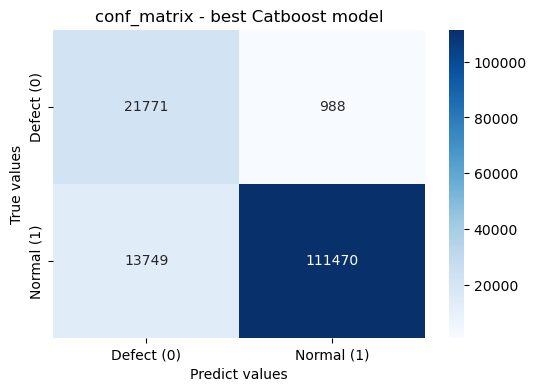

In [20]:
cm = confusion_matrix(y_test, y_test_pred_catboost)

plt.figure(figsize=[6, 4])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=['Defect (0)', 'Normal (1)'], 
           yticklabels=['Defect (0)', 'Normal (1)'])
plt.title("conf_matrix - best Catboost model")
plt.ylabel('True values')
plt.xlabel('Predict values')
plt.show()

In [21]:
print(classification_report(y_test, y_test_pred_catboost, 
                           target_names=['Defect', 'Normal']))

              precision    recall  f1-score   support

      Defect       0.61      0.96      0.75     22759
      Normal       0.99      0.89      0.94    125219

    accuracy                           0.90    147978
   macro avg       0.80      0.92      0.84    147978
weighted avg       0.93      0.90      0.91    147978



  feature  importance
4    PM_R   46.363674
1    DA_R   20.858159
2    AV_R   13.267626
0    DV_R   11.416097
3    AA_R    8.094444


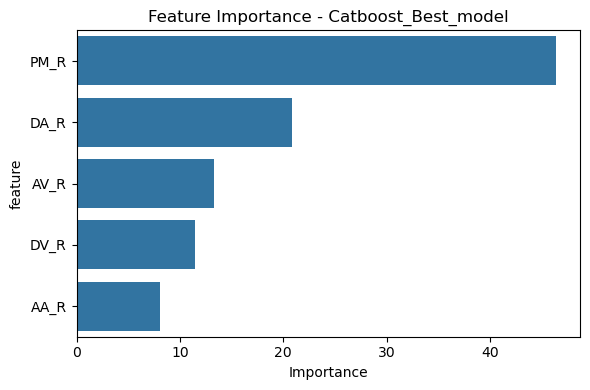

In [22]:
if hasattr(best_catboost_model, 'feature_importances_'): 
    feature_importance = pd.DataFrame({
        'feature': X.columns, 
        'importance': best_catboost_model.feature_importances_
    }).sort_values('importance', ascending=False)

    print(feature_importance)
    

    plt.figure(figsize = [6, 4])
    sns.barplot(data=feature_importance, x='importance', y='feature')
    plt.title("Feature Importance - Catboost_Best_model")
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

- **DV_R** - Arc voltage 
- **DA_R** - Arc curret
- **AV_R** - Wire feed speed
- **AA_R** - Wire feed current
- **PM_R** - Power

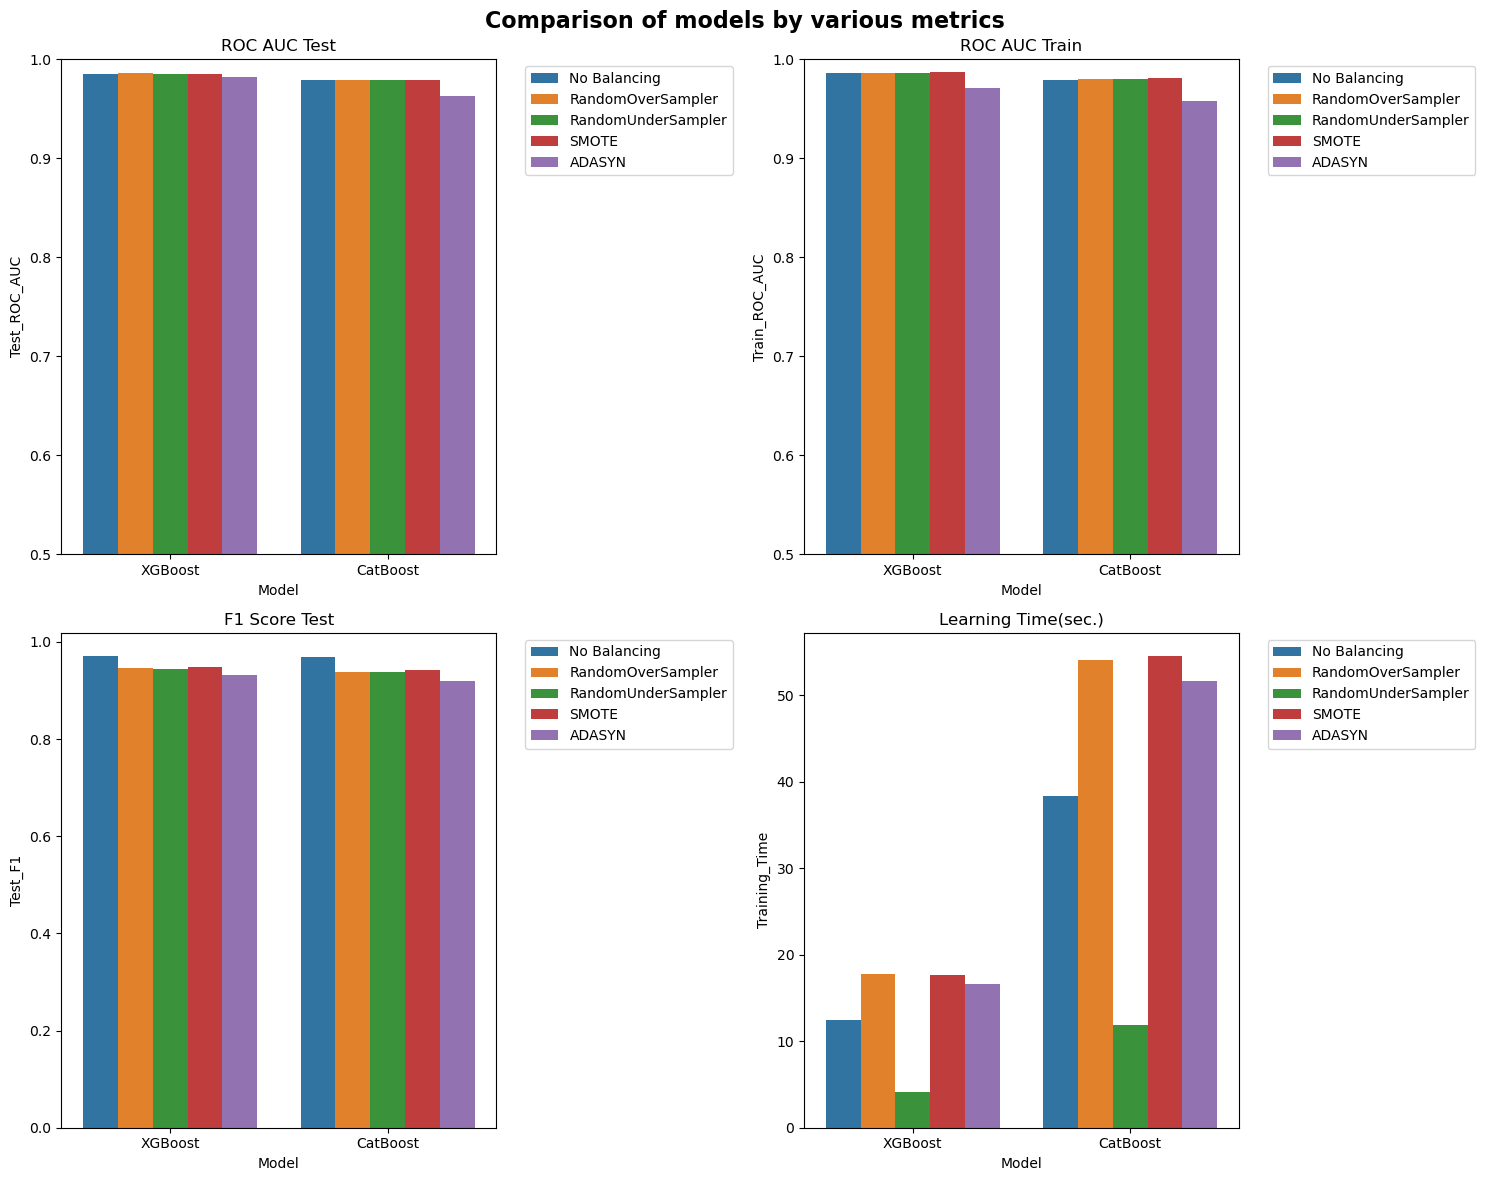

In [48]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Comparison of models by various metrics', fontsize=16, fontweight='bold')

sns.barplot(data=display_df, x='Model', y='Test_ROC_AUC', hue='Balancing', ax=axes[0,0])
axes[0,0].set_title('ROC AUC Test')
axes[0,0].set_ylim(0.5, 1.0)
axes[0,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

sns.barplot(data=display_df, x='Model', y='Train_ROC_AUC', hue='Balancing', ax=axes[0,1])
axes[0,1].set_title('ROC AUC Train')
axes[0,1].set_ylim(0.5, 1.0)
axes[0,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')


sns.barplot(data=display_df, x='Model', y='Test_F1', hue='Balancing', ax=axes[1,0])
axes[1,0].set_title('F1 Score Test')
axes[1,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

sns.barplot(data=display_df, x='Model', y='Training_Time', hue='Balancing', ax=axes[1,1])
axes[1,1].set_title('Learning Time(sec.)')
axes[1,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()